# #0 Journal paper critique

# #1 Reproduce figure with $\textrm{Bokeh}$

# #2 Reproduce figure in $\textrm{matplotlib}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

load data

In [4]:
data_dir = 'hw_2_data/'

In [19]:
ny_temp = np.loadtxt(data_dir + 'ny_temps.txt', skiprows=1)
google_stock = np.loadtxt(data_dir + 'google_data.txt', skiprows=1)
yahoo_stock = np.loadtxt(data_dir + 'yahoo_data.txt', skiprows=1)

In [22]:
google_t, google_v = google_stock[:, 0], google_stock[:, 1]
yahoo_t, yahoo_v = yahoo_stock[:, 0], yahoo_stock[:, 1]
ny_t, ny_v = ny_temp[:, 0], ny_temp[:, 1]

In [77]:
from matplotlib.ticker import MultipleLocator

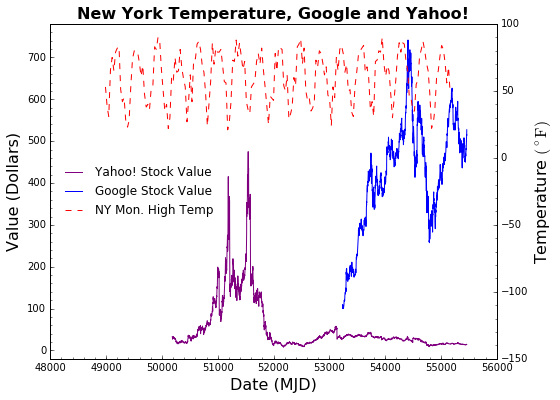

In [99]:
fs=16
fig, ax1 = plt.subplots(figsize=[8,6])

lns1 = ax1.plot(yahoo_t, yahoo_v, 'purple', label='Yahoo! Stock Value')
lns2 = ax1.plot(google_t, google_v, 'b-', label='Google Stock Value')
ax1.set_xlabel('Date (MJD)', fontsize=fs)
ax1.set_ylabel('Value (Dollars)', fontsize=fs)

ax1.set_ylim([-20, 780])
ax1.set_xlim([49000, 55000])

# add minor ticks
ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.yaxis.set_minor_locator(MultipleLocator(20))

# set font for title
font = {'family': 'sans-serif','color':  'black', 
        'weight': 'bold','size': fs}
ax1.set_title('New York Temperature, Google and Yahoo!', fontdict=font)

# turn off major and minor ticks from upper x axis
ax1.tick_params(axis='x', which='both', top='off')        

ax2 = ax1.twinx()
lns3 = ax2.plot(ny_t, ny_v, 'r--', label='NY Mon. High Temp')
ax2.set_ylabel('Temperature $(^\circ \mathrm{F})$', fontsize=fs)
ax2.set_ylim([-150, 100])
ax2.yaxis.set_minor_locator(MultipleLocator(10))

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', frameon=False)

plt.show()